In [1]:
pip install deap

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Required libraries
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, classification_report
import matplotlib.pyplot as plt
from deap import creator, base, tools, algorithms

# Load dataset from CSV
data = pd.read_csv('./eclipse.csv')

# Convert 'post' column to binary
data['post_binary'] = data['post'].apply(lambda x: 1 if x > 0 else 0)

# Prepare the feature matrix (X) and the target vector (y)
X = data.drop(columns=['plugin', 'filename', 'pre', 'post', 'post_binary'])  # Dropping non-numeric and target columns
y = data['post_binary']


In [3]:
# Create the selector object
selector = SelectKBest(chi2, k="all")
X_new = selector.fit_transform(X, y)

# Access the scores attribute to rank features
ranked_features = np.argsort(-selector.scores_)

# Genetic Algorithm for feature selection
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.choice, [0, 1])
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, X_new.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Define the evaluation function
def evalOneMax(individual):
    selected_features = [ranked_features[i] for i, val in enumerate(individual) if val == 1]
    X_train, X_valid, y_train, y_valid = train_test_split(X.iloc[:, selected_features], y, test_size=0.2)
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_valid)
    accuracy = accuracy_score(y_valid, predictions)
    return accuracy,

toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=100)
ngen = 40
crossover_prob = 0.7
mutation_prob = 0.2

algorithms.eaSimple(population, toolbox, crossover_prob, mutation_prob, ngen, stats=None, 
                    halloffame=None, verbose=True)


gen	nevals
0  	100   
1  	72    
2  	87    
3  	71    
4  	74    
5  	82    
6  	85    
7  	83    
8  	74    
9  	79    
10 	77    
11 	81    
12 	82    
13 	72    
14 	82    
15 	99    
16 	76    
17 	77    
18 	78    
19 	78    
20 	67    
21 	80    
22 	75    
23 	72    
24 	73    
25 	78    
26 	63    
27 	82    
28 	77    
29 	68    
30 	73    
31 	68    
32 	69    
33 	71    
34 	73    
35 	78    
36 	70    
37 	79    
38 	74    
39 	73    
40 	65    


([[0,
   0,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   0,
   1,
   1,
   0,
   0,
   0,
   1,
   0,
   1,
   1,
   0,
   1,
   0,
   0,
   0,
   1,
   0,
   1,
   0,
   1,
   0,
   0,
   1,
   0,
   0,
   0,
   1,
   0,
   1,
   1,
   0,
   0,
   1,
   1,
   1,
   0,
   1,
   0,
   0,
   0,
   0,
   1,
   0,
   1,
   0,
   0,
   1,
   0,
   0,
   1,
   1,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   1,
   0,
   1,
   0,
   1,
   0,
   1,
   1,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   0,
   0,
   1,
   1,
   0,
   1,
   0,
   1,
   1,
   1,
   0,
   1,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   0,
   0,
   1,
   0,
   0,
   1,
   1,
   1,
   1,
   0,
   1,
   0,
   0,
   1,
   1,
   1,
   1,
   0,
   1,
   1,
   0,
   1,
   1,
   0,
   1,
   0

Accuracy:  0.8400188768286928
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1792
           1       0.47      0.27      0.34       327

    accuracy                           0.84      2119
   macro avg       0.67      0.61      0.62      2119
weighted avg       0.81      0.84      0.82      2119



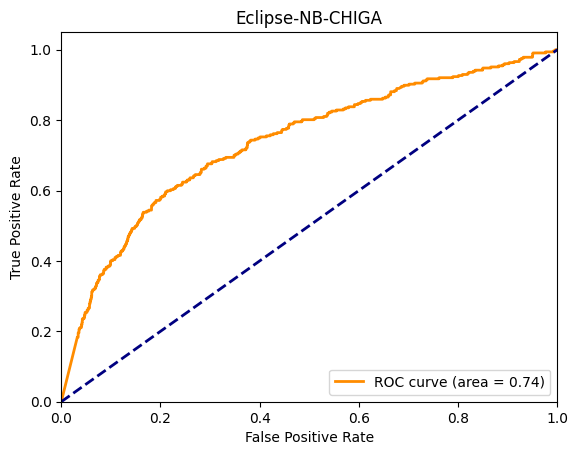

In [4]:
# Extract the best individual and get the corresponding feature subset
best_ind = tools.selBest(population, 1)[0]
best_features = [ranked_features[i] for i, val in enumerate(best_ind) if val == 1]

# Train and evaluate the NB model with the best features
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, best_features], y, test_size=0.2)

clf = GaussianNB()
clf.fit(X_train, y_train)
final_predictions = clf.predict(X_test)

# Test the classifier
print("Accuracy: ", accuracy_score(y_test, final_predictions))
print(classification_report(y_test, final_predictions))

# Plot the AUC-ROC curve
probas_ = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, probas_[:, 1]) 
roc_auc = auc(fpr, tpr)

#Save AUC values
df = pd.DataFrame({
    'AUC': roc_auc,
    'FPR': fpr,
    'TPR': tpr
})
df.to_csv('./AUC_Extracts/Eclipse/Eclipse_NB_CHIGA.csv', index=False)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Eclipse-NB-CHIGA')
plt.legend(loc="lower right")
plt.show()